# Logistic regression with pymc - Synthetic data

Now we will apply logistic regression to a real dataset. The chosen dataset is the Palmer Penguins dataset, very well suited for exploration & visualization. Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network. It contains data for 344 penguins. There are 3 different species of penguins in this dataset, collected from 3 islands in the Palmer Archipelago, Antarctica (ref: https://allisonhorst.github.io/palmerpenguins/.)

## 0. Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm
import arviz as az

We will be working with PyMC last version:

In [3]:
print("PyMC version:", pm.__version__)

PyMC version: 4.0.1


## 1. Data Exploration

Firstly we load the data:

In [4]:
penguins = pd.read_csv("penguins.csv")
penguins.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


There are 3 reprented species of pinguins: Adelie, Gentoo and Chinstrap. The species variable will be our dependent variable.

<BarContainer object of 3 artists>

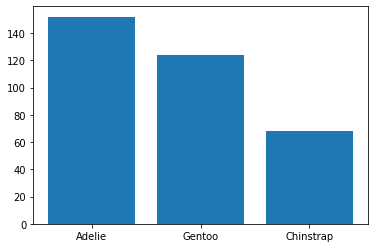

In [5]:
species_counts = dict(penguins['species'].value_counts())
plt.bar(species_counts.keys(), species_counts.values())

We are going to consider four variables as independent variables: 
- `bill_length_mm`
- `bill_depth_mm`
- `flipper_length_mm`
- `body_mass_g`

In [6]:
penguins = penguins.copy()[['species',
                        'bill_length_mm',
                        'bill_depth_mm',
                        'flipper_length_mm',
                        'body_mass_g']]
                        
penguins.dropna(inplace=True)
penguins.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


An easy and intuitive way of taking a first glance to our data is by doing a `seaborn` scatter matrix:

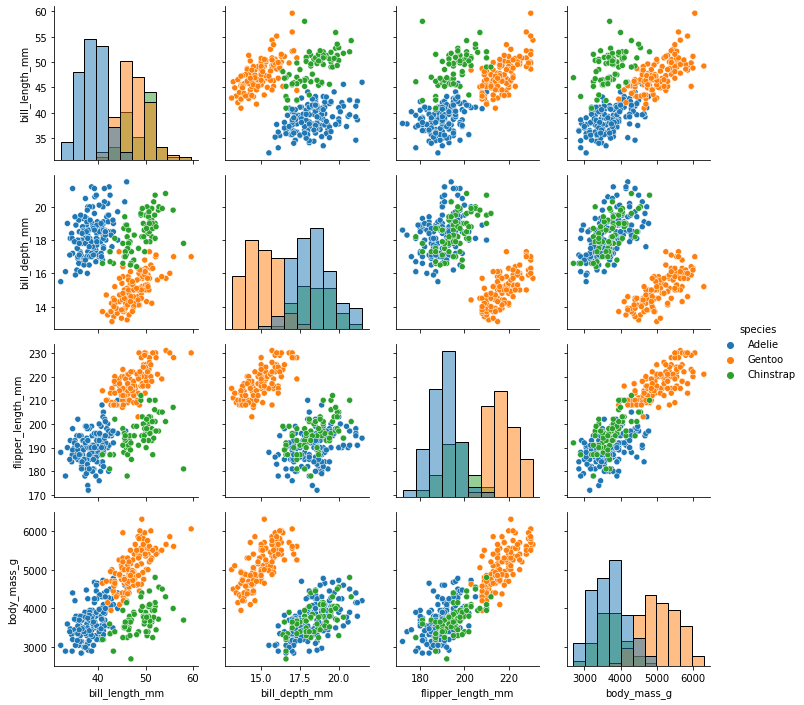

In [7]:
g = sns.PairGrid(penguins, hue="species")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## 1. Binary univariate classification

Again, we start by the most simple case, a two-class classification. We will just consider species `Adelie` and `Chinstrap`, i.e., $y \in \{0,1\}$. Again, here we will employ just independent variable, `flipper_length_mm`, i.e., $x \in \mathbb R$.

In [8]:
species = ['Adelie', 'Chinstrap']

p1 = penguins[penguins['species'].isin(species)]
y_0 = ((p1['species'] == species[0])*1).values
ind_vars = 'flipper_length_mm'
x_0 = p1[ind_vars].values

We can observe the distribution of our two 1-dimensional clusters with a violin plot:

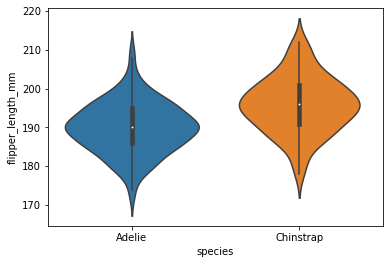

In [9]:
sns.violinplot(data=p1[['species','flipper_length_mm']], x='species', y='flipper_length_mm')
plt.show()

As we can appreciate, the two clusters are not separable.

Now that we have the data, we need to specify the model, that is, our prior distribution and likelihood. As the likelihood, we will chose a Bernoulli $(p= \theta )$ distribution, and for the priors we select $\alpha \sim N(\mu=0, \sigma=10)$ and $\beta\sim N(\mu=0, \sigma=1)$. 

We define our `PyMC` model as detailed above:

In [21]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    mu = alpha + pm.math.dot(x_0, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd', -alpha/beta)
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sample(5000, step, start, tune=2000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 49 seconds.


We can neatly see our defined model by calling `model_0`:

In [22]:
model_0

alpha ~ N(0, 10)
 beta ~ N(0, 1)
theta ~ Deterministic(f(alpha, beta))
   bd ~ Deterministic(f(beta, alpha))
   yl ~ Bern(theta)

Now we examine the sampling results for the four chosen chains for $\alpha$, $\beta$ and the decision boundary:

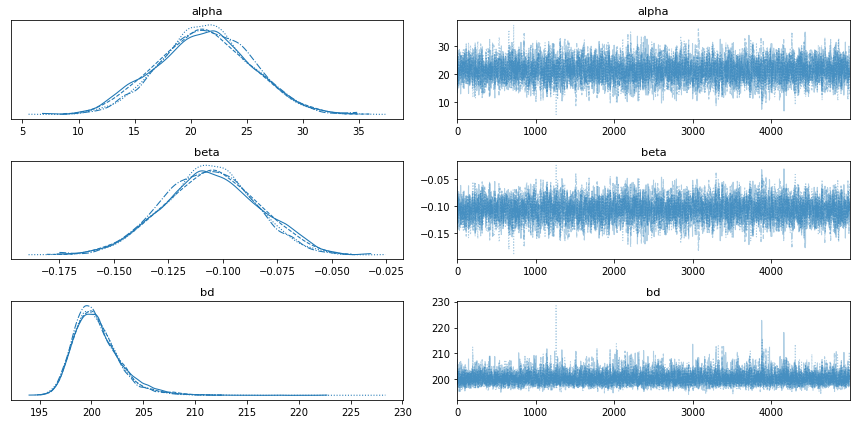

In [24]:
varnames = ['alpha', 'beta', 'bd']
az.plot_trace(trace_0, varnames)
plt.tight_layout()
plt.show()

And we can also print a summary of the posterior:

In [25]:
pm.summary(trace_0, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,21.262,4.136,13.561,28.999,0.072,0.051,3331.0,3339.0,1.0
beta,-0.106,0.021,-0.147,-0.067,0.000,0.000,3336.0,3380.0,1.0
bd,200.515,2.294,196.726,204.811,0.031,0.022,5908.0,6228.0,1.0


Now we can plot the data together with the fitted logistic curve. Firstly we make some format adjustments:

In [26]:
trace_pymc_0 = {}

theta_mc = np.array(trace_0.posterior['theta'])
trace_pymc_0['theta'] = theta_mc.reshape(theta_mc.shape[0]*theta_mc.shape[1], theta_mc.shape[2])
trace_pymc_0['bd'] = np.array(trace_0.posterior['bd']).flatten()

/tmp/ipykernel_2406/2278407942.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  theta_hpd = az.hdi(trace_pymc_0['theta'], hdi_prob=.95)[idx]


Text(0, 0.5, '$\\theta$')

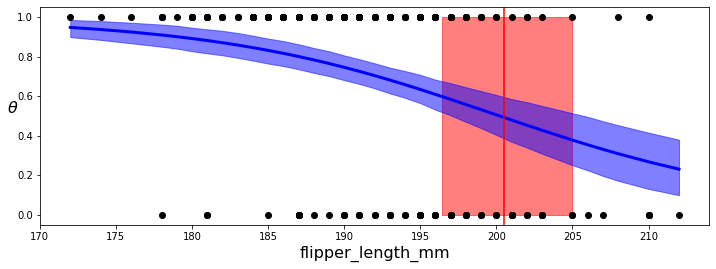

In [27]:
plt.figure(figsize=(12,4))
theta = trace_pymc_0['theta'].mean(axis=0)
idx = np.argsort(x_0.flatten())
plt.plot(x_0.flatten()[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_pymc_0['bd'].mean(), ymax=1, color='r')
bd_hpd = az.hdi(trace_pymc_0['bd'], hdi_prob=.95)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = az.hdi(trace_pymc_0['theta'], hdi_prob=.95)[idx]
plt.fill_between(x_0.flatten()[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel('flipper_length_mm', fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)

Where the fitted sigmoid function is the blue line and decision boundary is the red line, with their corresponding 95% HDIs. From this plot is easy to interpret the classification for each data point; points at the right side of the decision boundary will be classified as class 1 (Adelie), and those at the left side will be classified as class 0 (Chinstrap). Black dots are positioned along the y-axis according to their real class.

As we saw above, due to the non-separability of the clusters, the linear decision boundary is not able to classify samples without incurring in missclasifications.

## 2. Binary bivariate classification

Now let us go a step forward and include multiple features instead of just one, i.e., $x \in \mathbb R^N$, with $N>1$. For the sake of simplicity and to be able to produce clearer plots, we chose $N=2$. We chose independent variables `bill_length_mm` and `flipper_length_mm`.

In [28]:
species = ['Adelie', 'Chinstrap']

p1 = penguins[penguins['species'].isin(species)]
y = ((p1['species'] == species[0])*1).values
ind_vars = ['bill_depth_mm', 'flipper_length_mm']
x = p1[ind_vars].values

We can plot our two 2-dimensional clusters:

<AxesSubplot:xlabel='bill_depth_mm', ylabel='flipper_length_mm'>

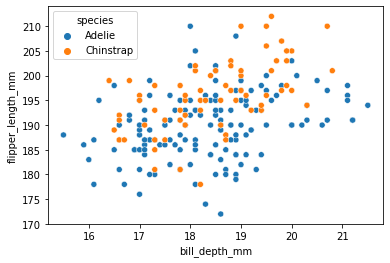

In [29]:
sns.scatterplot(data=p1, x="bill_depth_mm", y="flipper_length_mm", hue="species")

And again define our model as in the homonymous experiment with the synthetic dataset:

In [30]:
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=len(ind_vars))
    mu = alpha + pm.math.dot(x, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    bd = pm.Deterministic('bd', -alpha/beta[1]-beta[0]/beta[1]*x[:,0])  
    yl = pm.Bernoulli('yl', p=theta, observed=y)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_1 = pm.sample(5000, step, start, tune=2000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 107 seconds.


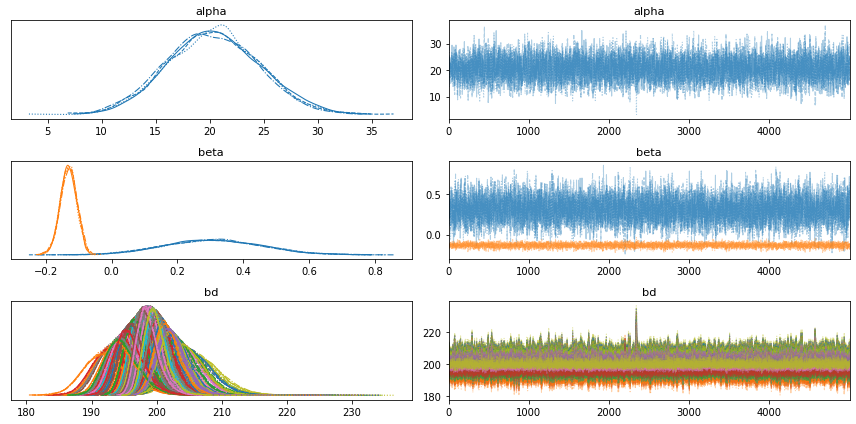

In [31]:
plots = az.plot_trace(trace_1, varnames)
plt.tight_layout()
plt.show()

Notice that now in the case of the $\beta$ plots, we are getting a set 4 lines (as we have seleceted 4 chains) for each of $\beta_0$ and $\beta_1$, and for the decision boundary now we get 100 set of curves, each for a data point.

In [32]:
trace_pymc_1 = {}

bd_mc = np.array(trace_1.posterior['bd'])
trace_pymc_1['bd'] = bd_mc.reshape(bd_mc.shape[0]*bd_mc.shape[1], bd_mc.shape[2])
trace_pymc_1['bd'] = trace_pymc_1['bd'][100:]

Finally we plot the decision boundary and its HDI interval:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2406/3706040106.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ld_hpd = az.hdi(trace_pymc_1['bd'], hdi_prob=.95)[idx]


Text(0, 0.5, 'flipper_length_mm')

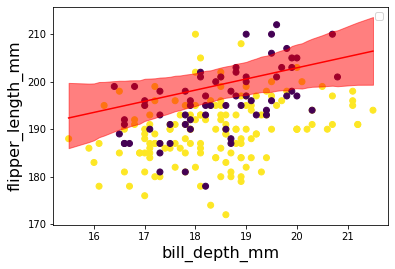

In [33]:
idx = np.argsort(x[:,0])
ld = trace_pymc_1['bd'].mean(0)[idx]
plt.scatter(x[:,0], x[:,1], c=y)
plt.plot(x[:,0][idx], ld, color='r')
plt.legend()

ld_hpd = az.hdi(trace_pymc_1['bd'], hdi_prob=.95)[idx]
plt.fill_between(x[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5)

plt.xlabel(ind_vars[0], fontsize=16)
plt.ylabel(ind_vars[1], rotation=90, fontsize=16)

Again, we are in front of a non-separable case and therefore our linear classifier is not able to display a great performance.

## Multinomial logistic regression

Finally, for the dependent variable we are going to use the three classes (Adelie, Gentoo and Chinstrap), and the four considered dependent variables. We are also going to standardize the data, since this will help the sampler to run more efficiently:

In [34]:
y_s = pd.Categorical(penguins['species']).codes
x_n = penguins.columns[1:]
x_s = penguins[x_n].values
x_s = (x_s - x_s.mean(axis=0))/x_s.std(axis=0)

Therefore in this case, the standard linear model to which we will apply the logistic function will be

$$\begin{pmatrix}
\alpha_0 \\
\alpha_1\\
\alpha_2\end{pmatrix} + \begin{pmatrix}
\beta_0^0 \\
\beta_1^0 \\
\beta_2^0
\end{pmatrix} x_0 + \begin{pmatrix}
\beta_0^1 \\
\beta_1^1 \\
\beta_2^1
\end{pmatrix} x_1 + \begin{pmatrix}
\beta_0^2 \\
\beta_1^2 \\
\beta_2^2
\end{pmatrix} x_2 + \begin{pmatrix}
\beta_0^3 \\
\beta_1^3 \\
\beta_2^3
\end{pmatrix} x_3, \quad \alpha, \beta^0, \beta^1, \beta^2, \beta^3 \in \mathbb R^3$$

Now we will make a few changes in the model definition with respect to the rest of the experiments. Besides of the correspondent changes in the `shape` parameter when defining the priors of $\alpha$ and $\beta$, we have employed the `softmax` from `math` in PyMC, which embodies a generalization of the logistic function to multiple dimensions. We change both the sample size and the tunning steps in order to remove all possible convergence warnings. The `tune` parameter on sample function indicates the number of iterations to tune; samplers adjust the step sizes, scalings or similar during tuning and will be drawn in addition to the number specified in the draws argument.

In [40]:
with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sigma=10, shape=3)
    beta = pm.Normal('beta', mu=0, sigma=2, shape=(4,3))
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.math.softmax(mu)
    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_s = pm.sample(8000, step, start, tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 5_000 tune and 8_000 draw iterations (20_000 + 32_000 draws total) took 857 seconds.


In [47]:
trace_pymc_s = {}

alpha = np.array(trace_s.posterior['alpha'])
alpha = np.array(trace_s.posterior['alpha'])
trace_pymc_s['alpha'] = alpha.reshape(alpha.shape[0]*alpha.shape[1], alpha.shape[2])
trace_pymc_s['beta'] = alpha.reshape(alpha.shape[0]*alpha.shape[1], alpha.shape[2])

In [48]:
trace_s.posterior['beta'].shape

(4, 8000, 4, 3)

Notice that this sampling experiment takes a remarkably longer time to execute.

Finally we can plot our sampling results for $\alpha$ and $\beta$ posteriors:

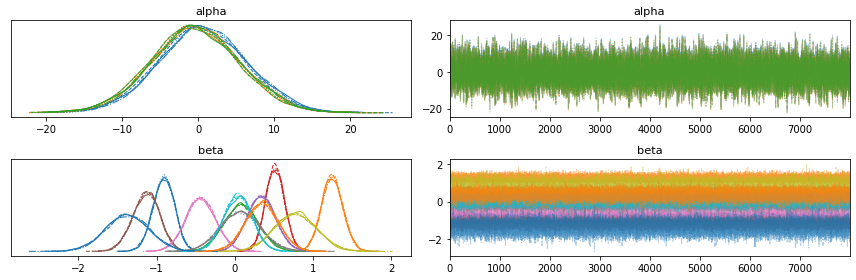

In [41]:
plots = az.plot_trace(trace_s, ['alpha','beta'])
plt.tight_layout()
plt.show()

Notice that now in the case of the $\beta$ plots, we are getting 12 lines for each of $\beta_i^j \quad i \in \{0,1,2\}, j \in \{0,1,2,3\} $.

We will not plot the decision boundary, given that this multi-dimensional case would be more intrincated and unintuitive that the previous ones.